### New York City Data Analysis: Correlation Between Income and SAT Score

Why this question? 

Across the US, SAT scores and income are correlated. The SAT has drawn criticism for being an indicator for a student's household income moreso than their skills. However, the school system in New York City operates differently from much of the remainder of the US. Instead of students automatically going to their neighborhood schools, many high-scoring students are pipelined into high-achieving schools such as the Specialized High Schools while students who do not perform as well on tests continue to attend school locally. This system creates a concentration of high-scoring students in a few small areas, and could mean that some schools in a particular zip code have extremely high average scores compared to other zip codes without a high-achieving school. 

I wanted to determine if the correlation between SAT scores and income still exists in NYC, given the concentration of high scorers in a small number of neighborhoods that are not necessarily where students live. I also wanted to show the scores on a map of NYC to see if it would be easy to pick out the zip codes which contain Specialized High Schools.

In [388]:
# Install packages necessary for data analysis and visualization
import folium
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import simplejson as json

Hypothesis to test: Income and SAT Score are correlated in NYC

### Data Gathering, Cleaning

In [389]:
# Step 0: Import primary data set.

sat_scores_orig = pd.read_csv('2010_SAT__College_Board__School_Level_Results.csv').set_index('DBN')

# Step 1: Clean Data Set (remove NAs, add total score column).

# Remove NAs. Here, a NA is represented as 's'.
sat_scores_no_na = sat_scores_orig[sat_scores_orig['Number of Test Takers']!= 's']

# Convert numeric columns to numeric type to perform mathematic operations. Currently, they are strings.
sat_scores_no_na['Critical Reading Mean'] = pd.to_numeric(sat_scores_no_na['Critical Reading Mean'])
sat_scores_no_na['Mathematics Mean'] = pd.to_numeric(sat_scores_no_na['Mathematics Mean'])
sat_scores_no_na['Writing Mean'] = pd.to_numeric(sat_scores_no_na['Writing Mean'])
# Also convert number of test takers to numeric for future calculations
sat_scores_no_na['Number of Test Takers'] = pd.to_numeric(sat_scores_no_na['Number of Test Takers'])

# Add total score column.
# Note: I am using column names with underscores to differentiate preexisting columns native to the dataset
# from those I created.
sat_scores_no_na['total_score'] = (
    sat_scores_no_na['Critical Reading Mean'] +
    sat_scores_no_na['Mathematics Mean'] +
    sat_scores_no_na['Writing Mean'])


# Step 2: Map High School locations to zip codes.

# Import data reference file including zip codes.
# Note: the content of this file was only used for mapping DBNs to zip codes.
school_safety_report = pd.read_csv('School_Safety_Report_NYC.csv')
zipcode_map = school_safety_report[['DBN', 'Postcode']].set_index('DBN')

# Merge dfs.
sat_scores_merge = sat_scores_no_na.merge(zipcode_map, how='inner', left_index=True, right_index=True)
sat_scores_final = sat_scores_merge.drop_duplicates().dropna() 

# Clean up zip code info, make string for merging. This df will be the basis of our schools and scores analysis.
sat_scores_zip_cleaned = sat_scores_final
sat_scores_zip_cleaned['zip'] = sat_scores_zip_cleaned['Postcode'].astype(int).astype(str)

# To test our hypothesis of SAT and income correlation, we need to ensure that each zip code
# (our key for matching SAT scores and incomes) has only one associated SAT score, as currently our df
# has multiple schools in some zip codes. We will average the scores across schools in the same zip.

# Average scores by zip and take only the average score and count information by zip.
sat_grouped_by_zip = sat_scores_zip_cleaned.groupby('zip').describe()
# See data note below for discussion on why these metrics were selected.
sat_mean_score = sat_grouped_by_zip['total_score'][['count', 'mean']]

# Step 3: Import new table with income information by zip code.

# Import information on income by zip code.
# Note: this is total income by zip code, which I will be dividing by the population to get per capita income.
# It is not the ideal metric, but it will provide an approximation of what we are looking for .
# AGI = adjusted gross income (i.e. total income, in this case it is stratified by zip)
agi_by_zip = pd.read_excel('income_agi_by_zip1.xlsx')
agi_by_zip['agi'] = agi_by_zip['agi_in_thousands'] * 1000

# Import information on population by zip code.
pop_by_zip = pd.read_csv('pop_by_zip1.csv')
pop_by_zip['zip'] = pop_by_zip['Zip Code ZCTA']

# Combine income and population info.
income_df_merge = pd.merge(agi_by_zip, pop_by_zip, on='zip', how='left')

# Calculate column for income per capita.
# Note that there are limitations to this data: population is 2010, agi is 2016.
income_df_merge['per_capita_income'] = income_df_merge['agi'] / income_df_merge['2010 Census Population']

# Clean up zip code info, make string for merging.
income_df = income_df_merge[['zip','per_capita_income']]
income_df['zip'] = income_df['zip'].astype(int).astype(str)

# Set index as zip codes.
income_zip_index = income_df.set_index(['zip'])

# Merge dataframes based on zip code so that we have one dataframe containing the count of schools in a zip,
# the average SAT score of those schools, and the per capita income of that zip code.
sat_income_by_zip = sat_mean_score.merge(income_zip_index, left_index=True, right_index=True)

# Rename column names to something more informative.
sat_income_by_zip.rename(
    columns={'mean': 'mean_sat_score_by_zip', 'per_capita_income': 'per_capita_income_by_zip'},
    inplace=True)

### Data Visualization: SAT Score by Zip Code

In [390]:
# Assemble data: take only mean scores by zip.
map_data = sat_income_by_zip['mean_sat_score_by_zip']

# Get list of zips on which we have data.
map_zips = map_data.index.tolist()

# Get json file to make a map.
with open('nyc_zip.geojson1.json', 'r') as jsonFile:
    all_nyc_zips = json.load(jsonFile)

# Remove zip codes for which we do not have data.
zips_with_data = []
for feature_dict in all_nyc_zips['features']:
    if feature_dict['properties']['postalCode'] in map_zips:
        zips_with_data.append(feature_dict)

# New json with only zips for which we have data.
zips_with_data_json = {
    'type': 'FeatureCollection', 
    'features': zips_with_data }

# Make a map!
score_map = folium.Map(location=[40.7306, -73.9352], zoom_start=11)
folium.Choropleth(
    geo_data=zips_with_data_json,
    fill_opacity=0.7,
    line_opacity=0.2,
    data=map_data,
    # Key to which to map zips:
    key_on='feature.properties.postalCode',
    columns=['zipcode', 'mean_sat_score_by_zip'],
    fill_color='BuPu',
    legend_name='1' 
).add_to(score_map)
score_map

### Data Visualization: Per Capita Income Estimate by Zip Code
It should be noted that as this calculation of per capita income is an estimation based on limited data, it may not perfectly correspond with previous research

In [391]:
# Make a map using geographical data assigned earlier.
# We can do this as it's all the same zip codes.
income_map = folium.Map(location=[40.7306, -73.9352], zoom_start=11)
folium.Choropleth(
    geo_data=zips_with_data_json,
    fill_opacity=0.7,
    line_opacity=0.2,
    data=sat_income_by_zip['per_capita_income_by_zip'],
    # Key to which to map zips:
    key_on='feature.properties.postalCode',
    columns=['zipcode', 'per_capita_income_by_zip'],
    fill_color='BuPu',
    legend_name='1'
).add_to(income_map)
income_map


### Further Descriptive Statistics using Matplotlib

Histogram: Scores

Text(0,0.5,'Number of Schools')

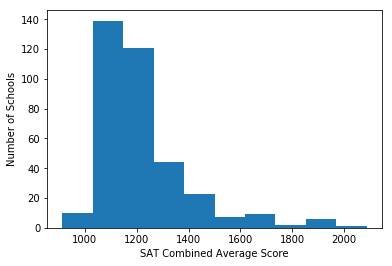

In [392]:
plt.hist(sat_scores_zip_cleaned['total_score'])
plt.xlabel('SAT Combined Average Score')
plt.ylabel('Number of Schools')

Histogram: Number of Test Takers

School Name              BROOKLYN TECHNICAL HIGH SCHOOL 
Number of Test Takers                               1047
Critical Reading Mean                                588
Mathematics Mean                                     652
Writing Mean                                         581
total_score                                         1821
Postcode                                           11217
zip                                                11217
Name: 13K430, dtype: object

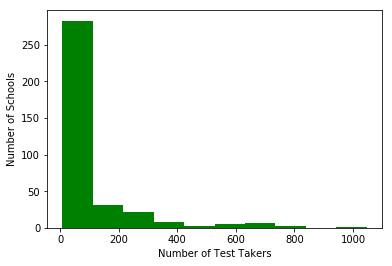

In [393]:
# Before graphing test-taker numbers data, we need to normalize the data, turning it into integers to ensure it
# is bucketed correctly by the histogram function.
plt.hist(sat_scores_zip_cleaned['Number of Test Takers'].astype('int32'), color='g')
plt.xlabel('Number of Test Takers')
plt.ylabel('Number of Schools')


# Which school is causing the results to skew?
sat_scores_zip_cleaned.loc[sat_scores_zip_cleaned['Number of Test Takers'].idxmax()]

# What can we conclude from this analysis? 
# Many schools in NYC are small, or at least have a small number of test takers

Histogram: Per Capita Income Distribution

Text(0,0.5,'Number of Zip Codes')

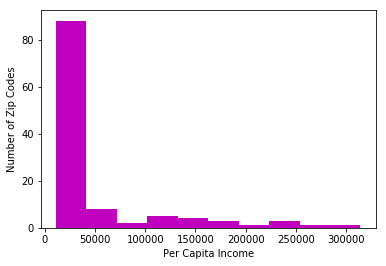

In [394]:
plt.hist(sat_income_by_zip['per_capita_income_by_zip'], color='m')
plt.xlabel('Per Capita Income')
plt.ylabel('Number of Zip Codes')

Scatterplot: Scores vs Income

Text(0,0.5,'Average SAT Score')

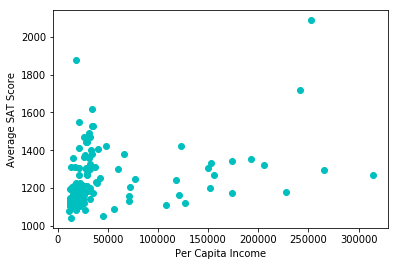

In [395]:
plt.scatter(
    sat_income_by_zip['per_capita_income_by_zip'], sat_income_by_zip['mean_sat_score_by_zip'], color='c')
plt.xlabel('Per Capita Income')
plt.ylabel('Average SAT Score')

In [396]:
# To test for correlation of variables, we must first determine whether they are normally distributed.
# This finding will determine whether we use parametric or non-parametric methods.
# Adapted from https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

# SAT Score:
print('Test of SAT Score Distribution Normalcy')
stat, p = stats.shapiro(sat_income_by_zip['mean_sat_score_by_zip'])
print('Statistic=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('SAT Score looks normally distributed')
else:
    print('SAT Score does not look normally distributed\n')
    
# Income:
print('Test of Per Capita Income Distribution Normalcy')
stat, p = stats.shapiro(sat_income_by_zip['per_capita_income_by_zip'])
print('Statistic=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('Per Capita Income looks normally distributed')
else:
    print('Per Capita Income does not look normally distributed')

Test of SAT Score Distribution Normalcy
Statistic=0.824, p=0.000
SAT Score does not look normally distributed

Test of Per Capita Income Distribution Normalcy
Statistic=0.617, p=0.000
Per Capita Income does not look normally distributed


### Hypothesis Test: Are Income and SAT Score correlated in NYC?

As noted above, our data inputs are _not_ normally distributed. We should use nonparametric methods of analysis to understand the correlation between these variables.

In [397]:
# Test correlation
# Notes on strength of correlation adapted from http://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf
stat, p = stats.spearmanr(sat_income['total_score'], sat_income['per_capita_calc'])

if p > 0.05:
    print('No correlation between SAT Score and Per Capita Income (fail to reject H0)\n')
else:
    print('Correlation between SAT Score and Per Capita Income (reject H0)\n')
    
if p < 0.05:
    if stat > 0:
        print('Positive Correlation\n')
    else:
        print('Negative Correlation\n')
else:
    print('N/A')
    
if p < 0.05:
    if abs(stat) <= .19:
        print('Very Weak Correlation')
    elif abs(stat) <= .39:
        print('Weak Correlation')
    elif abs(stat) <= .59:
        print('Moderate Correlation')
    elif abs(stat) <= .79:
        print('Strong Correlation')
    elif abs(stat) <= 1.0:
        print('Very Strong Correlation')
    else:
        print('N/A')
else:
    print('N/A') 

Correlation between SAT Score and Per Capita Income (reject H0)

Positive Correlation

Weak Correlation


### Discussion

*What can we learn from this analysis?*

Based on limited data, it appears that there is a relationship between per capita income in a zip code and the average SAT score in said zip code. Does this mean that a lower local income causes lower SAT scores? Not necessarily, and we are unable to say from this data set. There could be a variety of other external factors at play. Perhaps, for example, lower income areas have less of a cultural focus on college preparation in schools and thus students are not explicitly prepared for this exam.

However, this data provides a starting point for identifying potential areas where an external intervention may be welcome. If previous research has shown a particular initiative to be successful at raising SAT scores in lower income areas (and if raising SAT scores is an appropriate goal for the area), this analysis could identify candidates for such an initiative in New York City.

*Why use mean SAT scores and per capita zipcode income?*

Mean SAT Scores: This metric was chosen to represent the score component of analysis as it reflects the average score for a given school and zip code, taking into account outliers such as particularly high-performing or low-performing students at the school level or particularly high- or low-performing schools at the zip code level. For the use of mean scores in zip codes with multiple schools in particular, I selected this metric because I didn't believe that using a median score would be a good fit given the relatively small numbers of schools in each zip code. Given that the original data set supplied mean scores by SAT section by school, I felt as though using mean data would be a better use case for this input. That being said, there are limitations to using the mean as opposed to the median, as in any context, as outlier schools can affect the zip code's overall average. In a more policy-motivated analysis that was selecting school candidates for an intervention targeting lower performing schools, I would recommend looking at the data at school level in place of zip code level and potentially trying to access data on within-school variance in addition to mean scores by school. This data would provide a better picture of the school's overall performance. School-level mean data could then be aggregated by zip code as it appears here to identify schools that are underperforming in their area.

Per Capita Zipcode Income: This metric was chosen to represent the financial resources component of analysis to show how wealth is distributed across the city. The limitations of this metric are around how wealth is distributed within a particular zip code, as a small population of very wealthy individuals in an otherwise less-well-off zipcode would mean that the zip code has a high income per capita, even if this metric does not reflect the lived experience of the zip code's inhabitants. The contribution of this metric to the research question depends on the aspect of income we are testing and its proposed effect on SAT scores. Per capita zipcode income can provide information on how a school is resourced, while median household income by zipcode provides more information on the demographics of students attending the schools and whether or not they grew up with means. If we want to target interventions on areas where students grow up with lower household incomes, then median household income by zipcode would be the preferred metric. Per capita zipcode income is used here because it provides some data and due to data available, was easier to calculate. Note that here, it is calculated using population data from 2010 and income data from 2016, which could cause the per capita income to lean towards an overestimate. Assuming the 2010 census data is accurate, using 2016 gross income information is likely to be an overestimate as one would anticipate the population figures to trend upward, meaning that there are likely more people in any given zipcode in 2016 than 2010. Additionally, inflation could cause actual gross income figures in 2016 to be higher than in 2010; these numbers have not been adjusted for inflation.

#### Appendix
Evaluation of mean score standard deviations

Count of zip codes with data on multiple schools:
69

Count of zip codes with data on only one school:
47

Count of standard deviations equal to zero:
47

Information on Standard Deviation of Scores:
count     69.000000
mean     124.360526
std      100.225773
min        9.899495
25%       57.275649
50%       95.459415
75%      158.657913
max      436.284884
Name: std, dtype: float64


Text(0.5,1,'Distribution of standard deviation of mean scores within zip codes')

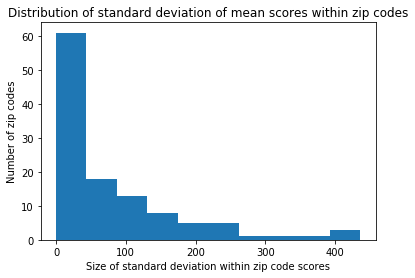

In [398]:
# How many zip codes have data on multiple schools? 
print('Count of zip codes with data on multiple schools:')
print(sat_grouped_by_zip['total_score']['count'][sat_grouped_by_zip['total_score']['count'] > 1].count())

# How many zip codes have data on only one school?
print('\nCount of zip codes with data on only one school:')
print(sat_grouped_by_zip['total_score']['count'][sat_grouped_by_zip['total_score']['count'] == 1].count())

# To confirm, does this equal the number of zero values for standard deviation?
print('\nCount of standard deviations equal to zero:')
print(sat_grouped_by_zip['total_score']['std'].isna().sum())

# How much variance is there in the standard deviation of mean total scores?
print('\nInformation on Standard Deviation of Scores:')
print(sat_grouped_by_zip['total_score']['std'].describe())

# How much does standard deviation vary? How many zip codes have a substantial standard deviation?
# Note: for ease of visualizing number of zero standard deviations, these values are plotted as '0' and are
# included in the first bucket
plt.hist(sat_grouped_by_zip['total_score']['std'].fillna(0))
plt.xlabel('Size of standard deviation within zip code scores')
plt.ylabel('Number of zip codes')
plt.title('Distribution of standard deviation of mean scores within zip codes')

While rather uncommon in this dataset, there are a number of zip codes that have a comparatively large standard deviation. This finding indicates considerable variance in the mean scores of schools in these zip codes, meaning that there are some well-performing schools paired with lower-performing schools (or exceptionally high-scoring schools paired with average, or average paired with low scoring). For zip codes where there is a large variance in scores, mean scores across zip codes are a less accurate method of measuring scores. Perhaps one of these zip codes has both an average-scoring school and one of the Specialized High Schools, a highly selective school, within its boundaries. The average of the scores of these schools may be high, but students travel from all over the city to attend the Specialized High School and its performance on tests isn't necessarily representative of the population of its zip code. Inclusion of Specialized High Schools in these locations and display of this scoring information by zip code may minimize the extent to which nearby schools are flagged as lower-scoring and given the resources they need to perform.